### Quantitative Asset Management | MGMTMFE 431 | Spring 2022

# Problem Set 4| Size and Value

Bryan Marty, CFA


bryan.marty.2022@anderson.ucla.edu

Due on Sunday 5/22 11:59pm PST. This is an individual assignment, but you can discuss it
with your classmates. If you discuss with other classmates, indicate their names in your write-up.
Please submit Python code (py file) as well as a separate write-up. Explain the procedure and
your answers clearly in the write-up (such that someone unfamiliar with the problem could solve
it). Code must be formatted as instructed in order to receive a grade. Use CCLE to submit your
answers.


### 1. Combine necessary CRSP and Compustat datasets needed to define size and book-to-market decile portfolios as defined in Fama and French (1992b), as well as the HML and SMB factors as defined in Fama and French (1993).

-  Detail which datasets you use, how you merged them, how you calculated the portfolios, and any differences between the building
   of the decile portfolios and the factors. Output should be between January 1973 and December 2021.
   
- Prepare the data you will need for the following questions of this problem set. Process should go from raw datasets to a dataset of portfolio returns. Here is a suggested output: dataframe, with each row corresponding to a unique Year-Month-Decile, with columns as follows:


<table>
    <tr>
        <td>
\begin{eqnarray}
     
            
     Variable Name  & VariableType & Variable Description\\
     ----------- & ---------- & -----------\\
     Year & integer & Year\\
     Month & integer & Month\\
     port &  integer & Portfolio decile (only relevant for size and book-to-market)\\
     Size Ret & float & Return of that size portfolio\\
     BTM Ret & float & Return of that book-to-market portfolio\\
     HML Ret & float & Return of the high-minus-low portfolio\\
     SMB Ret & float & Return of the small-minus-big portfolio\\
     ----------- & ----------- & -----------\\
    \end{eqnarray}
     
        <td>
    </tr>
</table>
            



In [2]:
import os
os.getcwd()
import pandas as pd
import numpy as np
import datetime as dt
import psycopg2
import wrds
from random import *
from dateutil.relativedelta import * 
from pandas.tseries.offsets import * 
from scipy import stats
import matplotlib.pyplot as plt 
import requests
import pandas_datareader
import datetime
import sqlalchemy as sa
import datetime as dt
from datetime import timedelta
from dateutil.parser import parse
from scipy.stats import kurtosis, skew


data_folder =  r"C:\Users\user\Documents\qam"

load_data = False
if load_data:
    print('Load Data')
else:
    print('Do not run WRDS scrips: move to datacleaning Pickle Files in the cleaning block.')
# WRDS login information SQL PULLS if necessary
   # folder where I’ll keep data
id_wrds = 'blacksheep'  # add your own wrds id
# It's useful to save your password: run the following
conn = wrds.Connection(wrds_username=id_wrds)
# conn.create_pgpass_file()



Do not run WRDS scrips: move to datacleaning Pickle Files in the cleaning block.
Loading library list...
Done


In [38]:
########################################################################################################################
## Compustat (data from wrds)
########################################################################################################################
conn = wrds.Connection(wrds_username=id_wrds)
cstat = conn.raw_sql("""
                    select a.gvkey, a.datadate, a.at, a.pstkl, a.txditc, a.fyear, a.ceq, a.lt, 
                    a.mib, a.itcb, a.txdb, a.pstkrv, a.seq, a.pstk, b.sic, b.year1, b.naics
                    from comp.funda as a
                    left join comp.names as b
                    on a.gvkey = b.gvkey
                    where indfmt='INDL'
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    """)

cstat4 = cstat
print(f"cstat4 downloaded")                     
# Pension data
# conn = wrds.Connection(wrds_username=id_wrds)
Pension = conn.raw_sql("""
                        select gvkey, datadate, prba
                        from comp.aco_pnfnda
                        where indfmt='INDL'
                        and datafmt='STD'
                        and popsrc='D'
                        and consol='C'
                        """)
# conn.close()
Pension4 = Pension                     
print(f"Pension4 downloaded")
########################################################################################################################
## CRSP-Compustat link table (data from wrds)
########################################################################################################################
# conn = wrds.Connection(wrds_username=id_wrds)
crsp_cstat=conn.raw_sql("""
                  select gvkey, lpermno as permno, lpermco as permco, linktype, linkprim, liid,
                  linkdt, linkenddt
                  from crspq.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """)
# conn.close()
crsp_cstat4 = crsp_cstat
print("crsp_stat4 downloaded")
########################################################################################################################
## CRSP returns (data from wrds)
########################################################################################################################
# conn = wrds.Connection(wrds_username=id_wrds)
crsp_raw = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd, b.siccd, b.naics,
                      a.ret, a.retx, a.shrout, a.prc
                      from crspq.msf as a
                      left join crspq.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where b.shrcd in (10,11)
                      and b.exchcd in (1,2,3)
                      """)



crsp_raw4 = crsp_raw
print("Crsp_raw 4 downloaded")
# Load CRSP Deslisting returns
# conn = wrds.Connection(wrds_username=id_wrds)
dlret_raw = conn.raw_sql("""
                        select permno, dlret, dlstdt
                        from crsp.msedelist
                        """, date_cols = ['dlstdt']) 
conn.close()
dlret_raw4 = dlret_raw
print('dlret_raw downloaded')

Loading library list...
Done
cstat4 downloaded
Pension4 downloaded
crsp_stat4 downloaded
Crsp_raw 4 downloaded
dlret_raw downloaded


In [39]:
l = [cstat, Pension, crsp_raw, dlret_raw, ccm]
for ii in l:
    print(ii.shape)

(545625, 17)
(146545, 3)
(3670718, 11)
(36408, 3)
(36627, 8)


In [40]:
print(crsp_raw.columns)
crsp_raw.head()

Index(['permno', 'permco', 'date', 'shrcd', 'exchcd', 'siccd', 'naics', 'ret',
       'retx', 'shrout', 'prc'],
      dtype='object')


,permno,permco,date,shrcd,exchcd,siccd,naics,ret,retx,shrout,prc
0,10000.0,7952.0,1986-01-31,10.0,3.0,3990.0,None,NaN,NaN,3680.0,-4.38
1,10000.0,7952.0,1986-02-28,10.0,3.0,3990.0,None,-0.26,-0.26,3680.0,-3.25
2,10000.0,7952.0,1986-03-31,10.0,3.0,3990.0,None,0.37,0.37,3680.0,-4.44
3,10000.0,7952.0,1986-04-30,10.0,3.0,3990.0,None,-0.10,-0.10,3793.0,-4.00
4,10000.0,7952.0,1986-05-30,10.0,3.0,3990.0,None,-0.22,-0.22,3793.0,-3.11


### pulling Fama French Explanation

In [41]:
########################################################################################################################
## Fama French 3 Factors  (data from French Website)
########################################################################################################################

pd.set_option('precision', 2)
data2 = pandas_datareader.famafrench.FamaFrenchReader('F-F_Research_Data_Factors',start='1900', end=str(datetime.datetime.now().year+1))
french = data2.read()[0] / 100 # Monthly data
french['Mkt'] = french['Mkt-RF'] + french['RF']

# Book-to-Market Portfolios
data2 = pandas_datareader.famafrench.FamaFrenchReader('Portfolios_Formed_on_BE-ME',start='1900', end=str(datetime.datetime.now().year+1))
# print(data2.read())
data2 = data2.read()[0][['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Hi 10']] / 100
data2.columns = 'BM01','BM02','BM03','BM04','BM05','BM06','BM07','BM08','BM09','BM10'
french = pd.merge(french,data2,how='left',on=['Date'])

# Size Portfolios
data2 = pandas_datareader.famafrench.FamaFrenchReader('Portfolios_Formed_on_ME',start='1900', end=str(datetime.datetime.now().year+1))
data2 = data2.read()[0][['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Hi 10']] / 100
data2.columns = 'ME01','ME02','ME03','ME04','ME05','ME06','ME07','ME08','ME09','ME10'
french = pd.merge(french,data2,how='left',on=['Date'])

# 25 Book-to-Market and Size Portfolios
data2 = pandas_datareader.famafrench.FamaFrenchReader('25_Portfolios_5x5',start='1900', end=str(datetime.datetime.now().year+1))
data2 = data2.read()[0].rename(columns={"SMALL LoBM":"ME1 BM1","SMALL HiBM":"ME1 BM5","BIG LoBM":"ME5 BM1","BIG HiBM":"ME5 BM5"}) / 100
french = pd.merge(french,data2,how='left',on=['Date'])

# Changing date format and save
french = french.reset_index().rename(columns={"Date":"date"})
french['date'] = pd.DataFrame(french[['date']].values.astype('datetime64[ns]')) + MonthEnd(0)
print('Data from Ken French Website:')
print(french.columns)
french4 = french



Data from Ken French Website:
Index(['date', 'Mkt-RF', 'SMB', 'HML', 'RF', 'Mkt', 'BM01', 'BM02', 'BM03',
       'BM04', 'BM05', 'BM06', 'BM07', 'BM08', 'BM09', 'BM10', 'ME01', 'ME02',
       'ME03', 'ME04', 'ME05', 'ME06', 'ME07', 'ME08', 'ME09', 'ME10',
       'ME1 BM1', 'ME1 BM2', 'ME1 BM3', 'ME1 BM4', 'ME1 BM5', 'ME2 BM1',
       'ME2 BM2', 'ME2 BM3', 'ME2 BM4', 'ME2 BM5', 'ME3 BM1', 'ME3 BM2',
       'ME3 BM3', 'ME3 BM4', 'ME3 BM5', 'ME4 BM1', 'ME4 BM2', 'ME4 BM3',
       'ME4 BM4', 'ME4 BM5', 'ME5 BM1', 'ME5 BM2', 'ME5 BM3', 'ME5 BM4',
       'ME5 BM5'],
      dtype='object')


In [42]:
# Throw into pickle
french4.to_pickle(data_folder + 'french4.pkl')
cstat4.to_pickle(data_folder + 'cstat4.pkl')
Pension4.to_pickle(data_folder + 'Pension4.pkl')
crsp_cstat4.to_pickle(data_folder + 'crsp_cstat4.pkl')
crsp_raw4.to_pickle(data_folder + 'crsp_raw4.pkl')
dlret_raw4.to_pickle(data_folder + 'dlret_raw4.pkl')  # ~254 KB



 


In [54]:


########################################################################################################################
## Compustat Cleaning (data from wrds)
########################################################################################################################


# cstat = pd.read_pickle(data_folder + 'cstat4.pkl')
# Pension = pd.read_pickle(data_folder + 'Pension4.pkl')
pension = Pension
pension['datadate'] = pd.to_datetime(pension['datadate'])

cstat_prba = pd.merge(cstat, pension, how = 'left', on = ['datadate','gvkey'])

# shareholder equity
cstat_prba['seq'] = np.where(cstat_prba['seq'].isnull(), cstat_prba['ceq'] + cstat_prba['pstk'], cstat_prba['seq']) 
cstat_prba['seq'] = np.where(cstat_prba['seq'].isnull(), cstat_prba['at'] + cstat_prba['lt'] - cstat_prba['mib'], cstat_prba['seq']) 
# preferred stock treatment 
cstat_prba['ps'] = np.where(cstat_prba['pstkrv'].isnull(), cstat_prba['pstkl'], cstat_prba['pstkrv'])
cstat_prba['ps'] = np.where(cstat_prba['ps'].isnull(), cstat_prba['pstkl'], cstat_prba['pstkrv'])
cstat_prba['ps'] = np.where(cstat_prba['ps'].isnull(), 0, cstat_prba['ps'])
                                                                        
# sum what is available, fillna 0 for itcb,txdv,then use if txdtc NA
cstat_prba['itcb']   = cstat_prba['itcb'].fillna(0)
cstat_prba['txdb']   = cstat_prba['txdb'].fillna(0)
cstat_prba['txditc'] = np.where(cstat_prba['txditc'].isnull(), cstat_prba['itcb'] + cstat_prba['txdb'], cstat_prba['txditc'])

# book equity, use prba if available. NAs in ps and txditc should be fillna 0
cstat_prba['be'] = np.where(cstat_prba['prba'].notna(), cstat_prba['seq'] - cstat_prba['ps'] + cstat_prba['txditc'] - cstat_prba['prba'], cstat_prba['seq'] - cstat_prba['ps'] + cstat_prba['txditc'])
cstat_prba['be'] = np.where(cstat_prba['be'] > 0, cstat_prba['be'], np.nan)

# number of years in cstat_prbustat
cstat_prba          = cstat_prba.sort_values(by = ['gvkey','datadate'])
cstat_prba['count'] = cstat_prba.groupby(['gvkey']).cumcount()
cstat_prba          = cstat_prba[['gvkey','datadate','year','be','count']]


In [56]:

########################################################################################################################
## CRSP Cleaning (data from wrds)
########################################################################################################################

# crsp_raw = pd.read_pickle(data_folder + 'crsp_raw4.pkl')
# crsp_cstat = pd.read_pickle(data_folder + 'crsp_cstat4.pkl')
# dlret_raw = pd.read_pickle(data_folder + 'dlret_raw4.pkl')
# # french = pd.read_pickle(data_folder = 'french4.pkl')

dlret = dlret_raw
#change variable format to integer
crsp_raw[['permco','permno','shrcd','exchcd']] = crsp_raw[['permco','permno','shrcd','exchcd']].astype(int)

# line up date with month end
crsp_raw['bin_date'] = crsp_raw['date'] + MonthEnd(0)

# add delisting retruns
dlret['permno'] = dlret['permno'].astype(int)
dlret['dlstdt'] = pd.to_datetime(dlret['dlstdt'])
dlret['bin_date'] = dlret['dlstdt'] + MonthEnd(0)

crsp = pd.merge(crsp_raw, dlret, how = 'left', on = ['permno','bin_date'])

# fill na dlret with 0
crsp['dlret'] = crsp['dlret'].fillna(0)

# retadj factors in delsiting returns
crsp['retadj'] = (1 + crsp['ret'])*(1 + crsp['dlret']) -1

# market equity
crsp['me'] = crsp['prc'].abs()*crsp['shrout']
crsp = crsp.drop(['dlret','dlstdt','prc','shrout'],axis = 1)
crsp = crsp.sort_values(by=['bin_date', 'permco', 'me'])

crsp.head()

,permno,permco,date,shrcd,exchcd,siccd,naics,ret,retx,bin_date,retadj,me
46636,10284,90,1925-12-31,10,1,7390.0,None,NaN,NaN,1925-12-31,NaN,24480.00
189050,11287,921,1925-12-31,10,1,3740.0,None,NaN,NaN,1925-12-31,NaN,59062.50
473993,14349,4083,1925-12-31,10,1,3310.0,None,NaN,NaN,1925-12-31,NaN,7750.00
482088,14461,4178,1925-12-31,11,1,5810.0,None,NaN,NaN,1925-12-31,NaN,21376.00
550326,15317,4955,1925-12-31,10,1,4000.0,None,NaN,NaN,1925-12-31,NaN,7965.75


In [57]:
### Aggregate Market Cap ###
# Sum of ME across different permno belonging to same permco at a given date
crsp_summe = crsp.groupby(['bin_date','permco'])['me'].sum().reset_index()
# largest market cap for permco/date
crsp_maxme = crsp.groupby(['bin_date','permco'])['me'].max().reset_index()
crsp1 = pd.merge(crsp,crsp_maxme,how = 'inner', on = ['bin_date','permco','me'])
# drop me column and replace with sum me
crsp1 = crsp1.drop(['me'], axis = 1)
# join with sum me to get correct market cap info
crsp2 = pd.merge(crsp1,crsp_summe, how = 'inner', on = ['bin_date','permco'])
# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by = ['permno', 'bin_date']).drop_duplicates()

# keep December market cap
crsp2['year'] = crsp2['bin_date'].dt.year
crsp2['month'] = crsp2['bin_date'].dt.month
decme = crsp2[crsp2['month'] == 12]
decme = decme[['permno','date','bin_date','me','year']].rename(columns = {'me':'dec_me'})



In [58]:
# portfolios reevaluated on June so its taking me back 6 months
crsp2['ffdate']  = crsp2['bin_date'] + MonthEnd(-6)
crsp2['ffyear']  = crsp2['ffdate'].dt.year
crsp2['ffmonth'] = crsp2['ffdate'].dt.month
crsp2['1+retx']  = 1 + crsp2['retx']
crsp2 = crsp2.sort_values(by = ['permno','date'])
# cumret by stock
crsp2['cumretx'] = crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()
# lag cumret
crsp2['lcumretx'] = crsp2.groupby(['permno'])['cumretx'].shift(1)
# lag market cap
crsp2['lme'] = crsp2.groupby(['permno'])['me'].shift(1)
# if first permno then use me/(1+retx) to remplace the missing value
crsp2['count'] = crsp2.groupby(['permno']).cumcount()
crsp2['lme']   = np.where(crsp2['count'] == 0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])
# baseline me
mebase = crsp2[crsp2['ffmonth'] == 1][['permno','ffyear','lme']].rename(columns = {'lme':'mebase'})
# merge result back to crsp as crsp3
crsp3 = pd.merge(crsp2, mebase, how = 'left', on = ['permno','ffyear'])
crsp3['wt'] = np.where(crsp3['ffmonth'] == 1, crsp3['lme'], crsp3['mebase'] * crsp3['lcumretx'])
decme['year'] = decme['year'] + 1
decme = decme[['permno','year','dec_me']]

# info as of june
crsp3_jun = crsp3[crsp3['month'] == 6]
crsp_jun  = pd.merge(crsp3_jun, decme, how = 'inner', on = ['permno','year'])
crsp_jun  = crsp_jun[['permno','date','bin_date','shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun = crsp_jun.sort_values(by = ['permno','bin_date']).drop_duplicates()


In [29]:
# CRSP_COMPUSTAT LINK TABLE

########################################################################################################################
## CRSP-Compustat link table (data from wrds)
########################################################################################################################

# conn = wrds.Connection(wrds_username = id_wrds)
# ccm = conn.raw_sql("""
#                    select gvkey, lpermno as permno, linktype, linkprim,
#                    linkdt, linkenddt
#                    from crsp.ccmxpf_linktable
#                    where substr(linktype, 1,1)='L' 
#                    and (linkprim ='C' or linkprim='P')
#                    """, date_cols=['linkdt', 'linkenddt'])
# conn.close()

In [59]:


########################################################################################################################
## CRSP-Compustat link table (data from wrds)
########################################################################################################################
ccm = crsp_cstat

ccm['linkenddt'] = ccm['linkenddt'].fillna(pd.to_datetime('today'))
ccm1 = pd.merge(cstat_prba[['gvkey','datadate','be','count']], ccm , how = 'left', on = ['gvkey'])
ccm1['yearend'] = ccm1['datadate'] + YearEnd(0)
ccm1['bin_date'] = ccm1['yearend'] + MonthEnd(6)
# set link date bounds
ccm2 = ccm1[(ccm1['bin_date'] >= ccm1['linkdt']) & (ccm1['bin_date'] <= ccm1['linkenddt'])]
ccm2 = ccm2[['gvkey','permno','datadate','yearend','bin_date','be','count']]
# link cstat and crsp
ccm_jun = pd.merge(crsp_jun, ccm2, how = 'inner', on = ['permno', 'bin_date'])
ccm_jun['beme'] = ccm_jun['be']*1000/ccm_jun['dec_me']

# NYSE size buckets exchcd = 1 and positive beme and positive me and shrcd in 10 11 and at least 2 years in comp
nyse = ccm_jun[(ccm_jun['exchcd'] == 1) & (ccm_jun['beme'] > 0) & (ccm_jun['me'] > 0) &  
                (ccm_jun['count'] >= 1) & ((ccm_jun['shrcd'] == 10) | (ccm_jun['shrcd'] == 11))]
# size breakdown
nyse_sz = nyse.groupby(['bin_date'])['me'].median().to_frame().reset_index().rename(columns = {'me':'sizemedn'})
# beme breakdown
nyse_bm = nyse.groupby(['bin_date'])['beme'].describe(percentiles = [0.3, 0.7]).reset_index()
nyse_bm = nyse_bm[['bin_date','30%','70%']].rename(columns = {'30%':'bm30', '70%':'bm70'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how = 'inner', on = ['bin_date'])

# join back size and beme breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how = 'left' , on = ['bin_date'])


# define size and b2mkt bins for factors
# its like a small or Big sort
def me_bin(row):
    if row['me'] == np.nan:
        value= ''
    elif row['me'] <= row['sizemedn']:
        value = 'S'
    else:
        value = 'B'
    return value

def bm_bin(row):
    """So this is saying if your book value/market value is less than 30% than you're a very large company,
    between = Medium sized company
    greater than 70 you're small (or a bank) """
    if 0 <= row['beme'] <= row['bm30']:
        value = 'L'
    elif row['beme'] <= row['bm70']:
        value = 'M'
    elif row['beme'] > row['bm70']:
        value = 'H'
    else:
        value = ''
    return value


In [60]:
# calculate size portfolio
ccm1_jun['me_port'] = np.where((ccm1_jun['beme'] > 0) & (ccm_jun['me'] > 0) & (ccm_jun['count'] >= 1), ccm1_jun.apply(me_bin, axis = 1),'')

# assign book to market portfolio
ccm1_jun['bm_port'] = np.where((ccm1_jun['beme'] > 0) & (ccm_jun['me'] > 0) & (ccm_jun['count'] >= 1), ccm1_jun.apply(bm_bin, axis = 1),'')

# get positive bm and value_port variable
ccm1_jun['posbm'] = np.where((ccm1_jun['beme'] > 0) & (ccm_jun['me'] > 0) & (ccm_jun['count'] >= 1), 1, 0)
ccm1_jun['valid_port'] = np.where((ccm1_jun['bm_port'] != ''),1,0)

# assign portfolio rank
ccm1_jun['me_decile'] = ccm1_jun.groupby('date')['me'].transform(lambda x: pd.qcut(x, 10,labels = False))
ccm1_jun['bm_decile'] = ccm1_jun.groupby('date')['beme'].transform(lambda x: pd.qcut(x, 10,labels = False))

# store portfolio assigment as of june
june = ccm1_jun[['permno','date','bin_date','bm_port','me_port','posbm','valid_port','me_decile','bm_decile']]
june['ffyear'] = june['bin_date'].dt.year

# merge with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','bin_date']]
ccm3  = pd.merge(crsp3,june[['permno','ffyear','me_port','bm_port','posbm','valid_port','me_decile','bm_decile']], how = 'left', on = ['permno','ffyear'])

# keeping only records that meet the criteria
ccm4 = ccm3[(ccm3['wt'] > 0) & (ccm3['posbm'] == 1) & (ccm3['valid_port'] == 1) & ((ccm3['shrcd'] == 10) | (ccm3['shrcd'] == 11))]


<ipython-input-60-cbe6d76e9a3b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june['ffyear'] = june['bin_date'].dt.year


In [61]:

# weighted average function, get positive bm and valid_port variable
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    #try/except to avoid Inf
    try:
        return (d*w).sum()/w.sum()
    except ZeroDivisionError:
        return np.nan

In [62]:
# value weighted returns
vwret = ccm4.groupby(['bin_date','me_port','bm_port']).apply(wavg, 'retadj', 'wt').to_frame().reset_index().rename(columns = {0:'vwret'})
vwret['sbport'] = vwret['me_port'] + vwret['bm_port']
# me and bm deciles
vwret_me = ccm4.groupby(['bin_date','me_decile']).apply(wavg, 'retadj', 'wt').to_frame().reset_index().rename(columns = {0:'vwret'})
vwret_bm = ccm4.groupby(['bin_date','bm_decile']).apply(wavg, 'retadj', 'wt').to_frame().reset_index().rename(columns = {0:'vwret'})
# firm count
vwret_n = ccm4.groupby(['bin_date','me_port','bm_port'])['retadj'].count().reset_index().rename(columns = {'retadj':'n_firms'})
vwret_n['sbport'] = vwret_n['me_port'] + vwret_n['bm_port']
# transpose
ff_factors = vwret.pivot(index = 'bin_date', columns = 'sbport', values = 'vwret').reset_index()
ff_nfirms = vwret_n.pivot(index = 'bin_date', columns = 'sbport', values = 'n_firms').reset_index()
# create SMB and HML factors
ff_factors['WH'] = (ff_factors['BH'] + ff_factors['SH'])/2
ff_factors['WL'] = (ff_factors['BL'] + ff_factors['SL'])/2
ff_factors['estHML'] = ff_factors['WH'] - ff_factors['WL']
ff_factors['WB'] = (ff_factors['BL'] + ff_factors['BM'] + ff_factors['BH'])/3
ff_factors['WS'] = (ff_factors['SL'] + ff_factors['SM'] + ff_factors['SH'])/3
ff_factors['estSMB'] = ff_factors['WS'] - ff_factors['WB']
ff_factors = ff_factors.rename(columns = {'bin_date': 'date'})
# n firm count
ff_nfirms['H'] = ff_nfirms[['SH','BH']].sum(axis =1) 
ff_nfirms['L'] = ff_nfirms[['SL','BL']].sum(axis =1)
ff_nfirms['HML'] = ff_nfirms[['L','H']].sum(axis =1)
ff_nfirms['B'] = ff_nfirms[['BL','BM','BH']].sum(axis =1)
ff_nfirms['S'] = ff_nfirms[['SL','SM','SH']].sum(axis =1)
ff_nfirms['SMB'] = ff_nfirms[['B','S']].sum(axis =1)
ff_nfirms['TOTAL'] = ff_nfirms['SMB']
ff_nfirms = ff_nfirms.rename(columns = {'bin_date':'date'})



In [63]:

# So I can show you I just going to do the top decile in each asked for column to show the results

vwret_me['Year_ME'] = vwret_me['bin_date'].dt.year
vwret_me['Month_ME'] = vwret_me['bin_date'].dt.month
vwret_bm['Year_BM'] = vwret_bm['bin_date'].dt.year
vwret_bm['Month_BM'] = vwret_bm['bin_date'].dt.month


output1SMB = ff_factors['estSMB']
output1HML = ff_factors['estHML']
outputyear_me = vwret_me[vwret_me['me_decile'] == 1]['Year_ME']
outputmonth_me = vwret_me[vwret_me['me_decile'] == 1]['Month_ME']
outputyear_bm = vwret_bm[vwret_bm['bm_decile']==1]['Year_BM'] 
outputmonth_bm =  vwret_bm[vwret_bm['bm_decile']==1]['Month_BM'] 

output1 = pd.concat( [ output1SMB, output1HML, outputyear_me, outputmonth_me, outputyear_bm, outputmonth_bm],
                    axis = 1)
output1 = output1.fillna("Not Decile 1")
output1 = output1.rename(columns={"estSMB": "SMB", 'estHML': 'HML', 'Year_ME': "YearME", "Month_ME": "MonthME", 'Year_BM': 'YearBM', 'Month_BM': "MonthBM"})
output1.head()
output1bm = vwret_bm[vwret_bm['bm_decile']==1]['vwret']
output = pd.concat([output1, output1bm], axis = 1)
output = output.rename(columns={'vwret': 'BookMarket'})
outputsize = vwret_me[vwret_me['me_decile'] == 1]['vwret']
outputQ1 = pd.concat([outputsize, output], axis = 1)
outputQ1 = outputQ1.rename(columns = {'vwret': 'Size'})
outputQ1 = outputQ1.fillna('Not Decile 1')
outputQ1.head()


,Size,SMB,HML,YearME,MonthME,YearBM,MonthBM,BookMarket
0,Not Decile 1,0.01,-0.0,Not Decile 1,Not Decile 1,Not Decile 1,Not Decile 1,Not Decile 1
1,-0.01,0.01,-0.0,1952.0,7.0,1952.0,7.0,0.01
2,Not Decile 1,0.0,0.01,Not Decile 1,Not Decile 1,Not Decile 1,Not Decile 1,Not Decile 1
3,Not Decile 1,-0.01,0.0,Not Decile 1,Not Decile 1,Not Decile 1,Not Decile 1,Not Decile 1
4,Not Decile 1,-0.01,0.02,Not Decile 1,Not Decile 1,Not Decile 1,Not Decile 1,Not Decile 1


# DATA Cleaning

Data is derived from
1. Compustat
2. Pension data
3. CRSP stock returns and delisting returns
4. linktable for CRSP and Compustat

Analysis is conducted by merging the necessary datasets in accordanc with FF (1992 and 1993) papers and cleaning specifics are provided below and in accordance with the problem set directions. 

### Universe : Following Ken French procedure:
common shares = (share codes 10 and 11) and  New York Stock Exchange equities,
American Stock Exchange, or the Nasdaq (exchange codes 1, 2, and 3) as specified in the paper. 
### Cleaning:

Recall: Shareholders’ equity (SHE) : variable reported in Compustat is “Stockholders’ Equity - Total” (SEQ). If not available, use “Common/Ordinary Equity - Total” (CEQ) plus “Preferred/Preference Stock (Capital) - Total” (PSTK). If not available, use “Assets - Total” (AT) minus “Liabilities - Total” (LT) minus “Minority Interest (Balance
Sheet)” (MIB). If not available, use AT minus LT.  This operation was performed in accordance wtih the notes. 

Recall:

Deferred taxes and investment tax credit (DT):  reported in Compustat is “Deferred Taxes and Investment Tax Credit” TXDITC. If not available, use “Investment Tax Credit (Balance Sheet)” (ITCB) plus “Deferred Taxes (Balance Sheet)”(TXDB). If not available, sum what is not missing. This was performed in accordance to the directions. 

Recall:
Book value of preferred stock (PS): Use redemption value, which is variable “Preferred Stock Redemption Value” (PSTKRV). If not available, use liquidation value, which is “Preferred Stock Liquidating Value” (PSTKL). If not available, use par value, which is “Preferred/Preference Stock (Capital) - Total” (PSTK).  This was performed in accordance to the directions. 

Recall:
Book Equity (BE): BE = SHE - P S + DT - P RBA (need value of SHE to compute BE, other variables included if not missing). Again, this was reported in accordance to the notes and hints section as described in the problem set. 

Recall:

Postretirement Benefit Asset” (PRBA) : Obtained from compustat’s Pension Annual data: merge to Compustat using Compustat’s global variable key (GVKEY).  Please see code as we used the link tables to combine both datasets for analysis. 

Missing Returns: Using the method of filling all missing values in crsp returns. The Monthly CRSP Stocks returns were generated by running the following steps.

For the first part, the return calculations both holding period and delisting period returns are calculated in the following manner from the class slides:

 ### $ r^{h}_{i,t} =  Return$
   if $r^{d}_{i,t}$ is missing
 ### $ r^{d}_{i,t} = Return$
   if $r^{h}_{i,t}$ is missing
 ### $(r^{h}_{i,t} + 1)(1 + r^{d}_{i,t}) -1 =  Return$  
   if both returns are not missing.
   
   
Lagged Market Cap for new Pmerno: If the company was just listed, use 1/retx
in place of lagged market cap (lme)

Replicating portfolios dates: It should be noted that the portfolios are formed
annualy, between June and July

Replicating portfolios breakpoints: Breakpoints from NYSE (exchd = 1), conditional upon positive book equity and positive market equity and atleast 2 year in
compustat.

Book to Market breakpoints: BM breakpoints are above or below the median
size where size breakpoints are determined by bottom 30%, over 70%, and middle 40%.

Portfolio Bins: Portfolios are formed into 10 bins (deciles), with equal number of
firms in each bin ( using qcut in python)   

---

### 2. For each size decile and the long-short portfolio report:

- annualized average excess returns
- annualized volatility 
- Sharpe Ratio
- skewness. 

Also report the correlation between the portfolios that you have constructed (the 10 portfolios and the long-short portfolio) and those from
French’s website.

In [64]:
# question 2
french2 = french.loc[french['date'] >= '1952-07-31'].reset_index()
print(f"dimensions of french2: {french2.shape}\n")

for ii in range(0,10):
    print(f"len(vwret_me[vwret_me['me_decile'] == ii]['vwret'])): \n {len(vwret_me[vwret_me['me_decile'] == ii]['vwret'])} ")
    print(f"len(FF_size.iloc[:,ii+1]) : \n {len(FF_size.iloc[:,ii+1])}")
    

dimensions of french2: (837, 52)

len(vwret_me[vwret_me['me_decile'] == ii]['vwret'])): 
 837 
len(FF_size.iloc[:,ii+1]) : 
 837
len(vwret_me[vwret_me['me_decile'] == ii]['vwret'])): 
 837 
len(FF_size.iloc[:,ii+1]) : 
 837
len(vwret_me[vwret_me['me_decile'] == ii]['vwret'])): 
 837 
len(FF_size.iloc[:,ii+1]) : 
 837
len(vwret_me[vwret_me['me_decile'] == ii]['vwret'])): 
 837 
len(FF_size.iloc[:,ii+1]) : 
 837
len(vwret_me[vwret_me['me_decile'] == ii]['vwret'])): 
 837 
len(FF_size.iloc[:,ii+1]) : 
 837
len(vwret_me[vwret_me['me_decile'] == ii]['vwret'])): 
 837 
len(FF_size.iloc[:,ii+1]) : 
 837
len(vwret_me[vwret_me['me_decile'] == ii]['vwret'])): 
 837 
len(FF_size.iloc[:,ii+1]) : 
 837
len(vwret_me[vwret_me['me_decile'] == ii]['vwret'])): 
 837 
len(FF_size.iloc[:,ii+1]) : 
 837
len(vwret_me[vwret_me['me_decile'] == ii]['vwret'])): 
 837 
len(FF_size.iloc[:,ii+1]) : 
 837
len(vwret_me[vwret_me['me_decile'] == ii]['vwret'])): 
 837 
len(FF_size.iloc[:,ii+1]) : 
 837


In [65]:
# question 2
french2 = french.loc[french['date'] >= '1952-07-31'].reset_index()

def summaryTable(vec,ff):
    data_length = len(vec)
    a = np.mean(vec) * 1200
    b = np.std(vec, ddof = 1) * np.sqrt(12) * 100
    c = a/b
    d = stats.skew(vec)
    e = stats.kurtosis(vec)
    f = stats.pearsonr(vec,ff)[0]
    t = np.mean(vec) / np.std(vec,ddof = 1) * np.sqrt(data_length)
    return(a,t,b,c,d,e,f)



FF_size = french2[['date','ME01','ME02','ME03','ME04','ME05','ME06','ME07','ME08','ME09','ME10']]

me_longshort = vwret_me[vwret_me['me_decile'] == 0]['vwret'].reset_index(drop=True) - vwret_me[vwret_me['me_decile'] == 9]['vwret'].reset_index(drop=True)
FF_longshort = FF_size.iloc[:,1].values - FF_size.iloc[:,10].values

q2_out = pd.DataFrame(np.zeros([10,7]),columns = ['Mean','t-Stat','SD','SR','Skewness','Kurtosis','Corr with FF'])

for ii in range(0,10):
    q2_out.iloc[ii] = summaryTable(np.array(vwret_me[vwret_me['me_decile'] == ii]['vwret']),np.array(FF_size.iloc[:,ii+1]))

q2_out.loc['LS'] = summaryTable(me_longshort,FF_longshort)


print(q2_out)


     Mean  t-Stat     SD    SR  Skewness  Kurtosis  Corr with FF
0   18.92    6.63  23.83  0.79      0.61      3.66          0.91
1   14.94    5.70  21.89  0.68      0.12      3.11          0.87
2   15.02    5.89  21.31  0.71     -0.06      2.91          0.90
3   14.46    5.63  21.44  0.67     -0.03      3.51          0.91
4   14.25    5.60  21.24  0.67     -0.24      2.92          0.93
5   14.45    5.87  20.56  0.70     -0.30      2.79          0.93
6   13.66    5.94  19.20  0.71     -0.53      3.02          0.95
7   13.37    6.13  18.21  0.73     -0.60      2.85          0.96
8   12.91    6.42  16.80  0.77     -0.53      2.67          0.96
9   11.47    6.60  14.50  0.79     -0.37      1.65          1.00
LS   7.45    3.09  20.17  0.37      1.29      5.86          0.87


# 3. For each book-to-market decile and the long-short portfolio report:
- annualized average
- excess returns
- annualized volatility
- Sharpe Ratio
- skewness. 

Also report the correlationbetween the portfolios that you have constructed (the 10 portfolios and the long-short portfolio)
and those from French’s website.

In [66]:
# Q3
#GET DataFrame for dates after July 1952
french3 = french.loc[french['date'] >= '1952-07-31'].reset_index()
# Set up the Book to Market Deciles and date FOR fAMA fRENCH
FF_value = french3[['date','BM01', 'BM02', 'BM03', 'BM04', 'BM05', 'BM06', 'BM07', 'BM08', 'BM09', 'BM10']]
# Set up by the output dataframe feeding an empty list as the index and columns names as the summary statistics
q3_out = pd.DataFrame(index=[], columns=['Mean', 'T-Stat', 'SD', 'SR','Skewness', 'Kurtosis', 'Corr with FF'])
# Create WML portfolio (bucket 9 returns - bucket 0 returns).reset_index()
bm_longshort = (vwret_bm[vwret_bm['bm_decile']==9]['vwret'].reset_index() - vwret_bm[vwret_bm['bm_decile']==0]['vwret'].reset_index())
#drop na values
bm_longshort = bm_longshort.dropna()
# Create dataframe with FamaFrench Long SHORT B SUBTRACTING TOP decile minus bottom decile liken to bm_longshort
FF_longshort = FF_value.iloc[:,10].values - FF_value.iloc[:,1].values # here these aren't buckets rather orgainzed on the columns but its the same idea 
# here lets loop through 0- 9 (10) where each iteration we are applyting the function on the columnt (vector) to achieve the statistic
for ii in range(0,10):
    q3_out.loc[ii] = summaryTable(vwret_bm[vwret_bm['bm_decile']==ii]['vwret'], FF_value.iloc[:, ii+1])
q3_out.loc['LS'] = summaryTable(bm_longshort['vwret'], FF_longshort)
q3_out


,Mean,T-Stat,SD,SR,Skewness,Kurtosis,Corr with FF
0,11.24,5.08,18.48,0.61,-0.33,2.01,0.98
1,10.90,5.60,16.25,0.67,-0.20,0.97,0.95
2,12.26,6.58,15.56,0.79,-0.33,1.62,0.95
3,11.56,6.08,15.88,0.73,-0.51,2.56,0.95
4,11.55,6.27,15.38,0.75,-0.35,2.20,0.95
5,12.23,6.64,15.38,0.79,-0.41,2.73,0.93
6,13.41,7.19,15.58,0.86,-0.27,3.07,0.94
7,13.33,6.94,16.04,0.83,-0.50,3.22,0.94
8,15.37,7.43,17.29,0.89,-0.30,3.07,0.93
9,18.02,7.28,20.68,0.87,-0.26,5.17,0.95


### 4. Has the value and size anomaly worked in the past few years? Show some empirical evidence.

The Long_short portfolio SMB did not do that well.  If one shorted it, then it would have worked out well. Generally no. This factor may have been perverted since QE commenced in 2008.

HML factor could have been a result of all this QE for the past 10 years. Given we didn't filter out bank stocks I suspect this factor is getting a boost due to our filters as banks usually have most of their assets liquid and reportable relative to other companies and have been greatly affected due to QE.



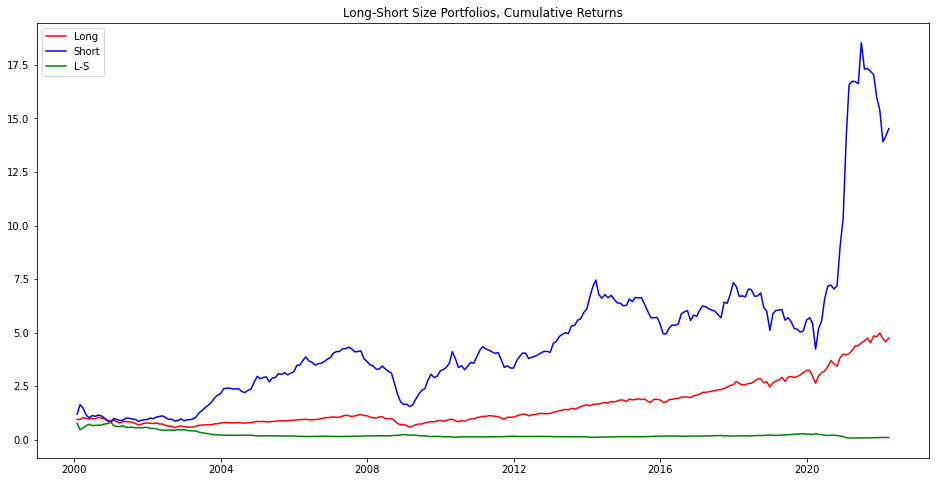

In [104]:
# Q4

vwret_me_post2000 = vwret_me[vwret_me['bin_date'].dt.year>=2000]
me_long = vwret_me_post2000[vwret_me_post2000['me_decile']==9]['vwret'].reset_index(drop = True)
me_short = vwret_me_post2000[vwret_me_post2000['me_decile']==0]['vwret'].reset_index(drop = True)
plt.figure(figsize=(16,8))
plt.title('Long-Short Size Portfolios, Cumulative Returns')
plt.plot(vwret_me_post2000[vwret_me_post2000['me_decile']==1]['bin_date'],
        (vwret_me_post2000[vwret_me_post2000['me_decile']==9]['vwret']+1).cumprod(), 'r-')
plt.plot(vwret_me_post2000[vwret_me_post2000['me_decile']==1]['bin_date'],
        (vwret_me_post2000[vwret_me_post2000['me_decile']==0]['vwret']+1).cumprod(), 'b-')
plt.plot(vwret_me_post2000[vwret_me_post2000['me_decile']==1]['bin_date'],
        (me_long - me_short+1).cumprod(), 'g-')
plt.legend(('Long', 'Short', 'L-S'))
plt.show()

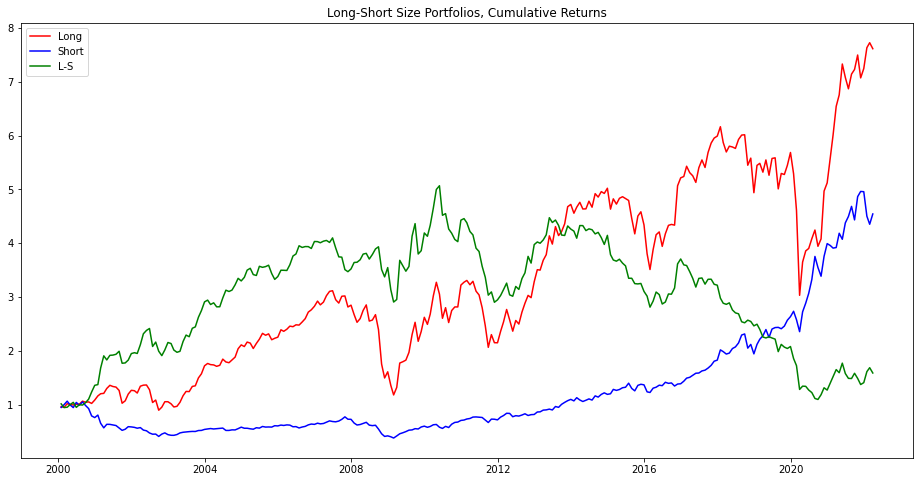

In [71]:


vwret_bm_post2000 = vwret_bm[vwret_bm['bin_date'].dt.year>=2000]
bm_long = vwret_bm_post2000[vwret_bm_post2000['bm_decile']==9]['vwret'].reset_index(drop = True)
bm_short = vwret_bm_post2000[vwret_bm_post2000['bm_decile']==0]['vwret'].reset_index(drop = True)
plt.figure(figsize=(16,8))
plt.title('Long-Short Size Portfolios, Cumulative Returns')
plt.plot(vwret_bm_post2000[vwret_bm_post2000['bm_decile']==1]['bin_date'],
        (vwret_bm_post2000[vwret_bm_post2000['bm_decile']==9]['vwret']+1).cumprod(), 'r-')
plt.plot(vwret_bm_post2000[vwret_bm_post2000['bm_decile']==1]['bin_date'],
        (vwret_bm_post2000[vwret_bm_post2000['bm_decile']==0]['vwret']+1).cumprod(), 'b-')
plt.plot(vwret_bm_post2000[vwret_bm_post2000['bm_decile']==1]['bin_date'],
        (bm_long - bm_short+1).cumprod(), 'g-')
plt.legend(('Long', 'Short', 'L-S'))
plt.show()

### 5. For both HML and SMB portfolios report:

- annualized average excess returns, 

- annualized volatility

- Sharpe Ratio

- skewness. 

Report correlations between the replicated factors and the
factor from French’s website. Have the factors been consistent across time? Show some empirical
evidence.


In [70]:
# q5
id_wrds = 'blacksheep'
# Here is an alternative way using wrds package (FF3 factors only...)
conn = wrds.Connection(wrds_username=id_wrds)
FF3 = conn.get_table(library='ff', table='factors_monthly')
conn.close()

FF3 = FF3[['date','smb','hml']]
FF3['date']=FF3['date']+MonthEnd(0)

FF3 = FF3[FF3['date'].dt.year<=2020]


# need to merge by date
ff_w_est = pd.merge(FF3, ff_factors[['date', 'estSMB', 'estHML']], how='inner', on=['date'])
ff_w_est = ff_w_est.dropna()
print('SMB factor correlation is:', stats.pearsonr(ff_w_est['smb'], ff_w_est['estSMB'])[0])
print('HML factor correlation is:', stats.pearsonr(ff_w_est['hml'], ff_w_est['estHML'])[0])

Loading library list...
Done
SMB factor correlation is: 0.9867576737872945
HML factor correlation is: 0.953821903433473


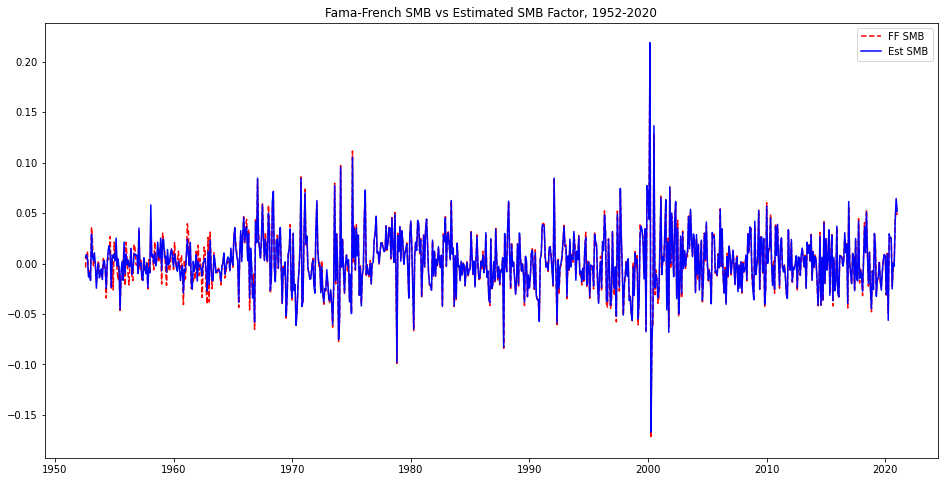

In [72]:
plt.figure(figsize=(16,8))
plt.title('Fama-French SMB vs Estimated SMB Factor, 1952-2020')
plt.plot_date(ff_w_est['date'], ff_w_est['smb'], 'r--')
plt.plot_date(ff_w_est['date'], ff_w_est['estSMB'], 'b-')
plt.legend(('FF SMB', 'Est SMB'), loc='upper right')
plt.show()

In [102]:
def summaryTable(vec,ff):
    """I want this returning a list not a tuple"""
    data_length = len(vec)
    a = np.mean(vec) * 1200
    b = np.std(vec, ddof = 1) * np.sqrt(12) * 100
    c = a/b
    d = stats.skew(vec)
    e = stats.kurtosis(vec)
    f = stats.pearsonr(vec,ff)[0]
    t = np.mean(vec) / np.std(vec,ddof = 1) * np.sqrt(data_length)
    return[a,t,b,c,d,e,f]


In [103]:

# Lets use the function to build a table.
table_smb = summaryTable(ff_w_est['smb'], ff_w_est['estSMB'])
table_hml = summaryTable(ff_w_est['hml'], ff_w_est['estHML'])

#create SMB dataframe
df_smb = pd.DataFrame(table_smb).T
df_smb.columns  =  ['Mean', 't-stat', 'Vol', 'Sharpe', 'Skewness', 'Kurtosis', 'Rho']
df_smb.index = ['SMB']
df_smb
#create HML dataframe
df_HML = pd.DataFrame(table_hml).T
df_HML.columns  =  ['Mean', 't-stat', 'Vol', 'Sharpe', 'Skewness', 'Kurtosis', 'Rho']
df_HML.index = ['HML']
# Make tables concat two dataframes
tables = pd.concat([df_HML, df_smb], axis = 0)
tables

,Mean,t-stat,Vol,Sharpe,Skewness,Kurtosis,Rho
HML,2.98,2.62,9.42,0.32,0.01,2.65,0.95
SMB,1.98,1.65,9.97,0.20,0.46,5.68,0.99


###  Analysis

We can see that both portfolios are much more highly correlated in the period after 1972.
This is most likely due to the quality of data from the given dataproviders.  hard to say which one is more accurate. What I found the most insightful is the HML Factor modle where we can really glean the short term reversal on the short side.  Notice how the rate of change in the short porfolio rebounds much faster than the long side when the market recovers.  Very interesting to SEE

---

### 6. Compare and contrast using the characteristic portfolios (Fama and French 1992) and the factor portfolios (Fama and French 1993).
This question might have been more interesting.   They trend in similar directions with differences most likely due to accounting and data collections issues.  One cannot be certain. 
